# Reading 15 million reviews 

*what is the best way to read 15 million reviews?* 

In [2]:
import gzip 
import json
import os

import pandas as pd

In [3]:
DIR = "./data"

In [4]:
def load_data(file_name, head=100):
    # 15739967
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            
            # only get review_text and review_stars
            data.append([d['review_text'], d['n_votes'], d['rating']])


            # break if reaches the headth line
            if (head is not None) and (count > head):
                break
    return data

In [5]:
# reviews = pd.DataFrame(load_data(os.path.join(
#     DIR, "goodreads_reviews_dedup.json.gz"))
# )

reviews = pd.read_csv("data/liwc_sample.csv")

In [6]:
reviews

,review_text,n_votes,rating,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,Mind blowingly cool. Best science fiction I've...,16,5,1,174,32.86,27.51,39.59,65.53,19.33,...,0.0,0.0,13.79,5.17,2.30,0.00,0.00,2.87,3.45,0
1,This is a special book. It started slow for ab...,28,5,1,358,63.49,35.27,64.13,45.44,17.90,...,0.0,0.0,14.80,5.31,3.07,1.12,0.00,0.84,4.47,0
2,I haven't read a fun mystery book in a while a...,6,3,1,86,22.00,6.98,91.21,95.15,12.29,...,0.0,0.0,16.28,6.98,2.33,0.00,1.16,4.65,1.16,0
3,"Fun, fast paced, and disturbing tale of murder...",22,4,1,179,23.12,10.38,83.40,27.64,19.89,...,0.0,0.0,15.64,5.03,2.79,0.00,0.00,1.12,6.70,0
4,A fun book that gives you a sense of living in...,8,4,1,79,92.60,32.92,56.26,99.00,15.80,...,0.0,0.0,7.59,6.33,0.00,0.00,0.00,0.00,1.27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Tessa Bailey is known for writing the dirtiest...,0,5,1,255,39.70,58.73,4.94,75.21,12.75,...,0.0,0.0,18.04,5.88,5.49,1.18,0.78,3.14,1.57,0
996,4.5 stars!! Sweet Filthy Boy is the first book...,0,4,1,273,88.48,19.55,61.86,85.37,17.06,...,0.0,0.0,14.29,5.13,4.03,0.00,2.20,1.47,1.47,0
997,This is an unexpectedly funny book with lots o...,1,4,1,179,41.04,69.35,29.07,99.00,19.89,...,0.0,0.0,12.29,3.91,3.35,0.00,1.12,2.79,1.12,0
998,I liked this installment better than the first...,1,4,1,93,32.41,14.43,66.26,84.42,13.29,...,0.0,0.0,17.20,4.30,1.08,0.00,6.45,4.30,1.08,0


In [7]:
reviews.to_csv(os.path.join(DIR, "tinysample.csv"), index=False)

# EDA

In [8]:
import nltk

from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import string

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [9]:
nltk.download('opinion_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessedoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

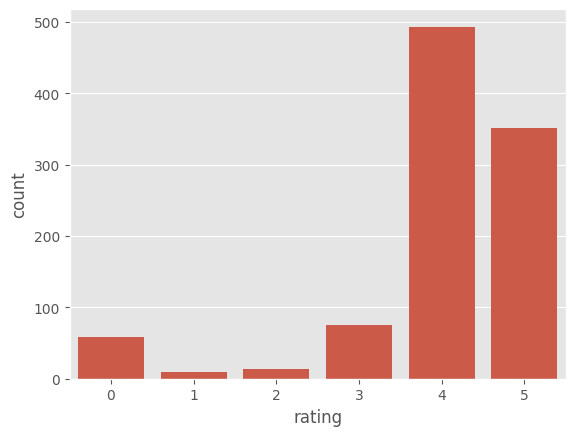

In [10]:
ax = sns.countplot(data=reviews, x='rating')

In [11]:
example = reviews.iloc[55]['review_text']
print(example)

A wonderful, beautifully written, poignant, subtle, and brilliant novel. 
 This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end. It is ultimately a story of regret. It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back. One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework. 
 But what I really loved about the novel is how slow and forcefully it builds. I don't think I've read a book that does that so well since Pride and Prejudice. In the beginning you think it's just a butler going on a motoring trip. And at the end, your heart is breaking. 
 Dignity is a big theme in the novel. Stevens attempts to define dignity several times throughout the novel - his definition generally has to do with self-respect and keeping on

In [12]:
sentences = sent_tokenize(example)
sentences

['A wonderful, beautifully written, poignant, subtle, and brilliant novel.',
 'This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end.',
 'It is ultimately a story of regret.',
 "It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back.",
 "One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework.",
 'But what I really loved about the novel is how slow and forcefully it builds.',
 "I don't think I've read a book that does that so well since Pride and Prejudice.",
 "In the beginning you think it's just a butler going on a motoring trip.",
 'And at the end, your heart is breaking.',
 'Dignity is a big theme in the novel.',
 'Stevens attempts to define dignity several times throughout the novel - his definition generally has to

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
def extract_sentiment_terms(sentence):
    # Tokenize words and tag part of speech
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    sentiment_terms = set()

    for word, tag in tagged_words:
        if word.lower() not in stop_words and word not in string.punctuation:
            if tag.startswith('JJ') or tag.startswith('RB'):
                if word.lower() in opinion_lexicon.positive() or word.lower() in opinion_lexicon.negative():
                    sentiment_terms.add(word)

    return sentiment_terms


In [15]:
sentiment_terms = set()
for sentence in sentences:
    sentiment_terms.update(extract_sentiment_terms(sentence))

In [16]:
# sentiment_terms

In [17]:
from gensim.models import Word2Vec
import networkx as nx

In [18]:
# get all sentiement terms from all reviews
sentiment_terms = set()
for review in reviews['review_text']:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        sentiment_terms.update(extract_sentiment_terms(sentence))

In [19]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

In [20]:
def learn_word_embeddings(processed_corpus):
    # Train a Word2Vec model on the processed corpus
    model = Word2Vec(sentences=processed_corpus,
                     vector_size=100, window=5, min_count=1, workers=4)
    return model       

In [21]:
model = learn_word_embeddings([word_tokenize(word) for word in sentiment_terms])

token = 'amazing'

if token in model.wv:
    print(f"{token}: {model.wv.most_similar(token)}")
else:
    synonyms = get_synonyms(token)

    for synonym in synonyms:
        if synonym in model.wv:
            print(f"{synonym}: {model.wv.most_similar(synonym)}")

amazing: [('humble', 0.2809358239173889), ('skillfully', 0.27375468611717224), ('paramount', 0.26316967606544495), ('overwhelmingly', 0.25781387090682983), ('dishonest', 0.2577782869338989), ('limited', 0.2552706301212311), ('lacking', 0.24891522526741028), ('best-selling', 0.24795375764369965), ('dire', 0.2474413961172104), ('superb', 0.23936116695404053)]


In [22]:
import liwc

parse, category_names = liwc.load_token_parser('data/LIWC2007_English100131.dic')

In [23]:
# LIWC 2007
from collections import Counter

gettysburg = '''Four score and seven years ago our fathers brought forth on
  this continent a new nation, conceived in liberty, and dedicated to the
  proposition that all men are created equal. Now we are engaged in a great
  civil war, testing whether that nation, or any nation so conceived and so
  dedicated, can long endure. We are met on a great battlefield of that war.
  We have come to dedicate a portion of that field, as a final resting place
  for those who here gave their lives that that nation might live. It is
  altogether fitting and proper that we should do this.'''
gettysburg_tokens = word_tokenize(gettysburg)
# now flatmap over all the categories in all of the tokens using a generator:
gettysburg_counts = Counter(category for token in gettysburg_tokens for category in parse(token))
# and print the results:
print(gettysburg_counts)

Counter({'funct': 53, 'relativ': 16, 'cogmech': 15, 'pronoun': 15, 'verb': 13, 'ipron': 11, 'preps': 10, 'conj': 9, 'social': 9, 'space': 9, 'auxverb': 9, 'affect': 8, 'present': 8, 'incl': 7, 'article': 6, 'time': 5, 'posemo': 5, 'ppron': 4, 'quant': 4, 'we': 3, 'past': 3, 'negemo': 3, 'anger': 3, 'tentat': 3, 'adverb': 3, 'motion': 2, 'certain': 2, 'death': 2, 'excl': 2, 'future': 2, 'number': 1, 'family': 1, 'humans': 1, 'cause': 1, 'achieve': 1, 'work': 1, 'leisure': 1, 'they': 1, 'discrep': 1})


In [24]:
essays = pd.read_csv('data/essays.csv')

In [25]:
essays = essays.rename(columns={
    'TEXT': 'text',
    'cEXT': 'extroversion',
    'cNEU': 'neuroticism',
    'cAGR': 'agreeableness',
    'cCON': 'conscientiousness',
    'cOPN': 'openness'
})

# subset the data text + big five

essays = essays[['text', 'extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']]

# convert n and y to 0 and 1
essays = essays.replace({'n': 0, 'y': 1})

/var/folders/lg/qth2myc91gj4tfy56qzfn3b40000gn/T/ipykernel_44517/1694335583.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  essays = essays.replace({'n': 0, 'y': 1})


In [26]:
essays

,text,extroversion,neuroticism,agreeableness,conscientiousness,openness
0,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,I can't believe it! It's really happening! M...,1,0,1,1,0
4,"Well, here I go with the good old stream of co...",1,0,1,0,1
...,...,...,...,...,...,...
2462,I'm home. wanted to go to bed but remembe...,0,1,0,1,0
2463,Stream of consiousnesssskdj. How do you s...,1,1,0,0,1
2464,"It is Wednesday, December 8th and a lot has be...",0,0,1,0,0
2465,"Man this week has been hellish. Anyways, now i...",0,1,0,0,1


In [53]:
seeds = pd.read_csv('data/seeds.csv')

In [54]:
seeds

,High Extraversion,Low Extraversion,High Agreeableness,Low Agreeableness,High Conscientiousness,Low Conscientiousness,High Emotional Stability,Low Emotional Stability,High Openness,Low Openness
0,party,anime,excited,fuck,ready for,xd,success,fucking,". "" ‐",u
1,cant wait,xd,blessed,fucking,to work,fucking,smh,sick of,‐,cant wait
2,girls,o.o,wonderful,shit,great day,fuck,lakers,depression,universe,ur
3,im,>.<,prayers,bitch,thankful,d:,basketball,fuck,art,cant
4,cant,manga,a great,damn,blessed,fuck you,beach,depressed,i've,dont
...,...,...,...,...,...,...,...,...,...,...
94,but im,‐ ^,awesome day,haters,off to work,the internet,in the lord,your status for,;,nman
95,with my girls,managed to,hope everyone,retarded,ready to get,black,tournament,a bit,sea,2 more
96,pool,read,so much fun,a bitch .,more days,unicorn,camp,. put this,damn,muna
97,last night,ni,thank,ugly,with the family,v =,beautiful day !,internet,blood,haha


In [70]:
# Assuming seeds is a DataFrame
seeds = pd.read_csv('data/seeds.csv')
seeds = {word: trait for trait in seeds.columns for word in seeds[trait].dropna().tolist()}

seeds

{'party': 'High Emotional Stability',
 'cant wait': 'Low Openness',
 'girls': 'High Extraversion',
 'im': 'Low Openness',
 'cant': 'Low Openness',
 'baby': 'High Extraversion',
 'love you': 'High Agreeableness',
 'lil': 'High Extraversion',
 'gettin': 'High Extraversion',
 'ya': 'High Extraversion',
 'chillin': 'High Emotional Stability',
 'dont': 'Low Openness',
 'night with': 'High Extraversion',
 'i love my': 'High Extraversion',
 'hit me up': 'High Extraversion',
 'goin': 'High Extraversion',
 'great night': 'High Extraversion',
 'cant wait to': 'Low Openness',
 'lovin': 'High Extraversion',
 'lets': 'High Extraversion',
 'girl': 'High Extraversion',
 'boys': 'High Extraversion',
 'beach': 'High Emotional Stability',
 'aint': 'Low Agreeableness',
 'fam': 'High Emotional Stability',
 'an amazing': 'High Agreeableness',
 'a blast': 'High Emotional Stability',
 'weekend': 'High Emotional Stability',
 'my girls': 'High Extraversion',
 'ready': 'High Emotional Stability',
 'wait to': 'H